In [3]:
#libraries and modules 

import numpy as np
import matplotlib.pyplot as plt


import keras
from keras.models import Sequential 
from keras.layers import Dense
from keras.utils import to_categorical

import tensorflow as tf

from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [4]:

#get test dataset

image_size = (180, 180)
batch_size = 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/test",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size)   
                                                         
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/train",  
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size)
                                                                
                                                                
                                                                
                                                                                                                   

Found 194 files belonging to 2 classes.
Using 156 files for training.
Found 1315 files belonging to 2 classes.
Using 263 files for validation.


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

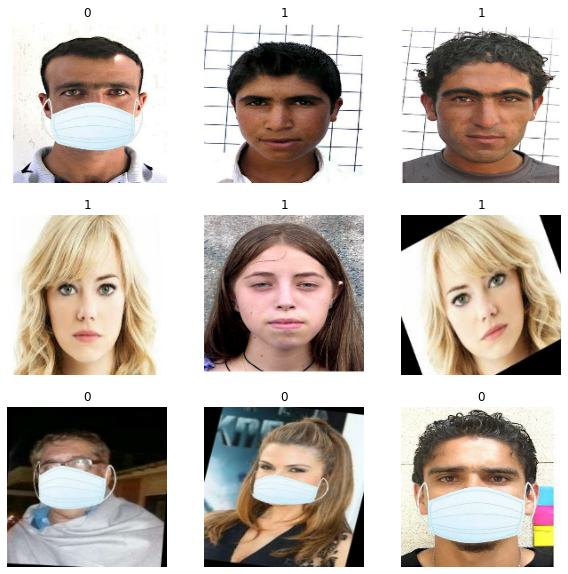

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [20]:
#train the model
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_data, epochs=epochs, callbacks=callbacks, validation_data=test_data,
)

Epoch 1/20
9/9 [==============================] - 71s 8s/step - loss: 0.5568 - accuracy: 0.7338 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 2/20
9/9 [==============================] - 61s 7s/step - loss: 0.1796 - accuracy: 0.9392 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 3/20
9/9 [==============================] - 57s 6s/step - loss: 0.1396 - accuracy: 0.9468 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 4/20
9/9 [==============================] - 71s 8s/step - loss: 0.1159 - accuracy: 0.9620 - val_loss: 0.6966 - val_accuracy: 0.5000
Epoch 5/20
9/9 [==============================] - 61s 7s/step - loss: 0.0500 - accuracy: 0.9810 - val_loss: 0.6985 - val_accuracy: 0.5000
Epoch 6/20
9/9 [==============================] - 58s 6s/step - loss: 0.0691 - accuracy: 0.9658 - val_loss: 0.7013 - val_accuracy: 0.5000
Epoch 7/20
9/9 [==============================] - 63s 7s/step - loss: 0.0597 - accuracy: 0.9734 - val_loss: 0.7062 - val_accuracy: 0.5000
Epoch 8/20
9/9 [==================

In [ ]:
img = keras.preprocessing.image.load_img(
    "face.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

print(predictions)

print(
    "This image is %.2f percent with mask and %.2f percent without mask."
    % (100 * (1 - score), 100 * score)
)

In [47]:

# SECOND PART -> WEBCAM Testing 
import cv2
import imutils
import numpy as np
from sklearn.metrics import pairwise

In [ ]:
if __name__ == "__main__":
    # initialize accumulated weight
    accumWeight = 0.5

    # get the reference to the webcam
    camera = cv2.VideoCapture(0)

    # region of interest (ROI) coordinates
    top, right, bottom, left = 10, 350, 225, 590

    # initialize num of frames
    num_frames = 0

    # calibration indicator
    calibrated = False


    while(True):
        # get the current frame
        (grabbed, frame) = camera.read()

        # resize the frame
        frame = imutils.resize(frame, width=700)

        # flip the frame so that it is not the mirror view
        frame = cv2.flip(frame, 1)

        # clone the frame
        clone = frame.copy()

        # get the height and width of the frame
        (height, width) = frame.shape[:2]

        # get the ROI
        roi = frame[top:bottom, right:left]
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (7, 7), 0)

        # to get the background, keep looking till a threshold is reached
        # so that our weighted average model gets calibrated
        if num_frames < 30:
            if num_frames == 1:
                print("[STATUS] please wait! calibrating...")
            elif num_frames == 29:
                print("[STATUS] calibration successfull...")
        else:
                
            #detect a face and draw a square around it
            face_data = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
            faces_found = face_data.detectMultiScale(gray, minSize = (30,30))
            faces_amount_found = len(faces_found)

            if faces_amount_found != 0:
                for (x,y,w,h) in faces_found:
                        #array for image
                        img_array = keras.preprocessing.image.img_to_array(clone)
                        #create batch axis
                        img_array = tf.expand_dims(img_array, 0)
                        
                        #make prediction
                        predictions= model.predict(img_array)
                        score = predictions[0] 
                        
                        print(score)
                        if(score > 0.43):
                            #draw red
                            cv2.rectangle(clone, (x,y), 
                                        (x +h, y+w), 
                                        (0,0,255), 5)
                            cv2.putText(clone, "No Mask", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)                      
        
                        else: 
                            #draw green
                            cv2.rectangle(clone, (x,y), 
                                        (x +h, y+w), 
                                        (0, 255,0), 5)
                            cv2.putText(clone, "Mask Detected", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
                
                        
            # show the thresholded image
            cv2.imshow("Video Feed", clone)

        # increment the number of frames
        num_frames += 1

        # observe the keypress by the user
        keypress = cv2.waitKey(1) & 0xFF

        # if the user pressed "q", then stop looping
        if keypress == ord("q"):
            break
            
    # free up memory
    camera.release()
    cv2.destroyAllWindows()


[STATUS] please wait! calibrating...
[STATUS] calibration successfull...
[0.4273213]
[0.42630643]
[0.427011]
[0.42664313]
[0.4266646]
[0.42700797]
[0.4273545]
[0.4296791]
[0.4255554]
[0.42610013]
[0.42613426]
[0.42701417]
[0.42726657]
[0.42751047]
[0.4275899]
[0.4277056]
[0.4278589]
[0.42773297]
[0.42760587]
[0.42763925]
[0.42770585]
[0.4284998]
[0.42849484]
[0.4277301]
[0.42758125]
[0.42775825]
[0.4278952]
[0.4276678]
[0.4274299]
[0.4282749]
[0.42820746]
[0.4281003]
[0.42786804]
[0.4280274]
[0.42923468]
[0.42792016]
[0.4272802]
[0.4271763]
[0.4274613]
[0.42623764]
[0.42575872]
[0.42568278]
[0.42582577]
[0.42603305]
[0.42594272]
[0.42689365]
[0.42633426]
[0.4258082]
[0.42828834]
[0.4244888]
[0.42423993]
[0.42412347]
[0.42403167]
[0.42410865]
[0.42423683]
[0.42428428]
[0.4243215]
[0.4247066]
[0.4240115]
[0.42508173]
[0.42559946]
[0.42577648]
[0.42584276]
[0.42560717]
[0.42547306]
[0.42575487]
[0.4256248]
[0.42564082]
[0.4255979]
[0.42548153]
[0.4256841]
[0.42553812]
[0.42557603]
[0.4255

In [73]:

camera.release()
cv2.destroyAllWindows()